#Preperation

In [ ]:
!git clone #anonymous github

In [ ]:
!pip install transformers
!pip install wget
!pip install lime
!pip install jsonlines

In [ ]:
%cd /content/MultiViz/structured-framework/

In [ ]:
!mkdir data
%cd data

In [ ]:
!mkdir flickr30k
%cd flickr30k

Note: The download link from official website changes every time

In [ ]:
!wget https://dl2.boxcloud.com/d/1/b1!9JVKgkXoYrDVfiBqw9Ke-dGlWyoIK3wjCl5svVL4ZvEZsIwfBtb5x4vkMU1KVGafhijIAbTcJ5RePEtz9T_qtE8fuctGHPsvK6ticOJcRf8EaDna0ifj3e3psXROXIJ8KSiCrkNXL-YeDygSV1g6qNndFu0BCLo8Ea8RRV7VmOuQ8eKRzzZ20Bb7qw7VIA1NrQfDNXJxPZG5Yk5IC7o2wFgiT_QIfumGvwZ7AyuT_cHTrpj0El80dtlyF60KVTYU35YMI8T0utiDu6nvRrlPxJQWL3H1fpRnYrhYTW8lid9FhirsofPqg8pq_IfszcPn6qNuYQjsCT3gx3ZEEdfW3Jj6oSWdXEyE96whVT0QznAOZDsbf-q_MHizgeCjV9a_OzowGxSZRN8m4X-m2b-msY5GqN8hWaKBfeZMQ3pfR790Ko-0NmD8L8Q_hjnIhuZKZq4dnbYS0nbITouDXaNjW6yZr_xo1kddONR4-Pqtr7jdVM1XSJECwDz8PsLf5eaCWeZkGsQO_uM9HgbKxA4h-9Pe855PcoZ0t41gg4jxd6dlGoV_x2ZSxdFtHTwVrc9il_Z7RdIaGoYJ2ot8M7Uuv4XY9cDyUZW4OJthtv97xWq4rFWMcIWySEZnjYR00AX6NvgIem04_86kz50IeWmOUvFWnIEvGFXtiI9bqwzueLiANc6PixFHkwxLIUvyZVJSXRnFahctHgAgfLjpHjXUVTAi6I8Kh8osS6WBLOpFV3QOLn7x3KkyD0unVG5No1Cz91teM06ng1ZeKsWjxpHxwagwb6FYLJ0iJcwKGJBtQ0Fm61Q1B1KYeEP4GQmOoWKfneIHdutjJQDAedCbr4kmNLhYVoNg3DV2c4oBo_wR0FTmWyK8zmvwzHjVsYNMBJv-l1642HP4EtPTJx8NduqEinKjrNQZlNvwYhx73cCGRQvPuMS1QBkiXB8TkDnBdCLfCH-buas720QfvdGSilDnFzpKQdOr1JcGRUg_2uQ8mYMBz5J0hJ_U0rcRgHdwAjgS9VNGhH0nqPil6AnKHQYIrleOkv6TFnasaYXVxLq_UpH9vpxDgg5ZjPgdjkuJXRsaw9VH0XrTekpkli2Jptjm75AxXMLA8L4ip9QEfx_10w3AvtIcF6z9AVY2kU6Np7RRCntEuXjk4F-DYmZI6eLcPYtXoZgJ8XJsgo_kYtf4DhYgdixRnp02WNcwEwYw067mzQHnidxc3Aiuq_c9ezxe3W4KvchE5dB1ZBhCtZVpk47KwSIxttrQ_elB38SAIFhUCdlFzY307frqO20BDVC6meAlgrZKeZPIP0NK6lM4YQ../download

In [ ]:
!wget https://github.com/BryanPlummer/flickr30k_entities/raw/master/annotations.zip

In [ ]:
!tar -xf download

In [ ]:
!unzip annotations.zip

In [ ]:
!wget https://sid.erda.dk/share_redirect/CrLpUMgIKh/annotations/valid_ann.jsonl

In [ ]:
!mv valid_ann.jsonl val_ann.jsonl

In [ ]:
%cd ../..

In [ ]:
!mkdir tmp
!mkdir visuals

#Define Flickr_CLIP analysis model

Note: following the definition of the abstract analysis model definition in analysismodel.py to define the Flickr_CLIP model

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import torch
import json
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
import cv2
from models.analysismodel import analysismodel
import PIL
import random


class Flickr30KClip:
    def __init__(self, device="cuda", target_idx=0):
        self.device = device
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(
            self.device
        )
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.modalitynames = ["image", "text"]
        self.modalitytypes = ["image", "text"]
        self.target_idx = target_idx

    def getunimodaldata(self, datainstance, modality):
        if modality == "image":
            return cv2.resize(np.asarray(PIL.Image.open(datainstance[0])), (224, 224))
        elif modality == "text":
            return datainstance[1][self.target_idx]
        else:
            raise ValueError

    # TODO: Check if this is needed for Flickr30k
    def getcorrectlabel(self, datainstance):
        pass

    def forward(self, datainstance):
        with torch.no_grad():
            im = PIL.Image.open(datainstance[0])
            sentences = [datainstance[1][self.target_idx]]
            inputs = self.processor(
                text=sentences,
                images=im,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
            )
            for k, v in inputs.items():
                inputs[k] = v.to(self.device)
            outputs = self.model(**inputs)
            return outputs.logits_per_image  # image-text similarity score

    # in this case we don't do batching, so we just do one at a time:
    def forwardbatch(self, datainstances):
        outs = []
        for di in datainstances:
            outs.append(self.forward(di))
        return outs

    def getlogitsize(self):
        return 1

    def getlogit(self, resultobj):
        return resultobj[0]

    # TODO: We cannot implement prelinear for this,
    # as there are two different heads
    def getprelinear(self, resultobj):
        pass

    # TODO: Check if this needs to be updated
    def getpredlabel(self, resultobj):
        return resultobj[0][[self.target_idx]].item()

    # TODO: We cannot implement prelinear for this,
    # as there are two different heads
    def getprelinearsize(self):
        pass

    def replaceunimodaldata(self, datainstance, modality, newinput):
        if modality == "image":
            randname = "tmp/flickr30k" + str(random.randint(0, 100000000)) + ".jpg"
            plt.imsave(randname, newinput)
            return randname, datainstance[1][self.target_idx]
        elif modality == "text":
            return datainstance[0], newinput
        else:
            raise ValueError

    def getgrad(self, datainstance, target_idx):
        self.model.zero_grad()
        im = PIL.Image.open(datainstance[0])
        sentences = [datainstance[1][self.target_idx]]
        inputs = self.processor(
            text=sentences,
            images=im,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
        )
        for k, v in inputs.items():
            inputs[k] = v.to(self.device)
        inputs.pixel_values.requires_grad = True
        outputs = self.model(**inputs)
        outputs.logits_per_image[0][target_idx].backward()
        return [inputs.pixel_values.detach()[0]], [inputs.pixel_values.grad.detach()[0]]

    def getgradtext(self, datainstance, target_idx, alltarget=False, prelinear=False):
        self.model.zero_grad()
        im = PIL.Image.open(datainstance[0])
        sentences = [datainstance[1][self.target_idx]]
        inputs = self.processor(
            text=sentences,
            images=im,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
        )

        text_embedding = None
        text_ids = None
        text_grad = None

        def hook_forward(module, input, output):
            nonlocal text_embedding, text_ids
            text_embedding = output[0]
            text_ids = input[0]

        def hook_backward(module, input, output):
            nonlocal text_grad
            text_grad = output[0][0]

        forward_handle = (
            self.model.text_model.embeddings.token_embedding.register_forward_hook(
                hook_forward
            )
        )
        backward_handle = (
            self.model.text_model.embeddings.token_embedding.register_backward_hook(
                hook_backward
            )
        )

        for k, v in inputs.items():
            inputs[k] = v.to(self.device)

        inputs.pixel_values.requires_grad = True

        outputs = self.model(**inputs)

        probas = outputs.logits_per_image
        if alltarget:
            torch.sum(probas[0]).backward(create_graph=True)
        else:
            probas[0][target_idx].backward()

        forward_handle.remove()
        backward_handle.remove()

        res = torch.sum(text_embedding * text_grad, dim=1)

        return res, parse(sentences[0]), inputs.pixel_values, text_ids

    def getdoublegrad(self, datainstance, target, targetwords, alltarget=True):

        res, di, normed_image, text_ids = self.getgradtext(
            datainstance, target, alltarget=alltarget
        )
        ac = 0.0
        for id in targetwords:
            ac += torch.abs(res[id])

        rets = torch.autograd.grad(ac, normed_image)
        return rets[0], di, text_ids

    # TODO: If this is correct
    def private_prep(self, datainstance):
        with torch.no_grad():
            im = PIL.Image.open(datainstance[0])
            sentences = [datainstance[1][self.target_idx]]
            inputs = self.processor(
                text=sentences,
                images=im,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
            )
        return inputs


def parse(sent):
    words = []
    for word in sent[:-1].split(" "):
        words.append(word)
    words.append("<end>")
    words.insert(0, "<start>")
    return words

#Flickr_CLIP analysis

In [ ]:
!mkdir visuals

In [ ]:
import PIL.Image as Image
from transformers import CLIPTokenizer
from tqdm import tqdm

from datasets.flickr30k import Flickr30kDataset
from visualizations.visualizelime import visualizelime

from analysis.emap import emap_print_report
from analysis.dime import dime
from analysis.unimodallime import rununimodallime
from visualizations.visualizegradient import*
from analysis.gradientbased import get_saliency_map

In [ ]:
#processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
#model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

datas = Flickr30kDataset("val")
analysismodel = Flickr30KClip()

###Gradient-based


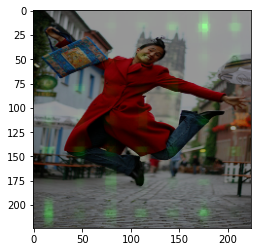

In [ ]:
idx = 5
target = 0

# get data instance
instance = datas.getdata(idx)

# get the model predictions
preds = analysismodel.forward(instance)

# compute and print grad saliency with and without multiply orig:
saliency = get_saliency_map(instance, analysismodel, 0)
grads = saliency[0]
t = normalize255(torch.sum(torch.abs(grads), dim=0), fac=255)
heatmap2d(
    t,
    f"visuals/flickr30k-clip-{idx}-{target}-saliency.png",
    instance[0],
)




###Second Order Gradient

  0%|          | 0/10 [00:00<?, ?it/s]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


['three</w>', 'small</w>', 'dogs</w>']


 10%|█         | 1/10 [00:50<07:32, 50.27s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['his</w>', 'frying</w>', 'pan</w>']


 20%|██        | 2/10 [01:48<07:17, 54.74s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['white</w>', 'facial</w>', 'and</w>', 'chest</w>', 'markings</w>']


 30%|███       | 3/10 [02:36<06:01, 51.65s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['white</w>', 'and</w>', 'orange</w>', 'tulips</w>']


 40%|████      | 4/10 [03:23<04:58, 49.78s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['two</w>', 'boys</w>', ',</w>', 'two</w>', 'girls</w>']


 50%|█████     | 5/10 [04:09<04:02, 48.41s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['black</w>', 'shirt</w>', 'and</w>', 'brown</w>', 'pants</w>']


 60%|██████    | 6/10 [04:56<03:12, 48.04s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['suitcase</w>']


 70%|███████   | 7/10 [05:44<02:23, 47.98s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['woman</w>', 'in</w>', 'a</w>', 'jean</w>', 'jacket</w>', 'and</w>', 'black</w>', 'sunglasses</w>']


 80%|████████  | 8/10 [06:31<01:35, 47.64s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['white</w>', 'dog</w>', 'with</w>', 'brown</w>', 'ears</w>']


 90%|█████████ | 9/10 [07:17<00:47, 47.26s/it]ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


['pink</w>', 'food</w>', 'tray</w>']


100%|██████████| 10/10 [08:05<00:00, 48.54s/it]


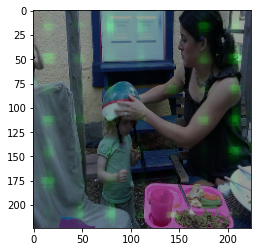

In [ ]:
target_idx = 0

instance_text_target_ids = {
    50: {"ids": [1, 2, 3], "text": "three small dogs"},
    100: {"ids": [15, 16, 17], "text": "his frying pan"},
    150: {"ids": [5, 6, 7, 8, 9], "text": "white facial and chest markings"},
    200: {"ids": [11, 12, 13, 14], "text": "white and orange tulips"},
    250: {"ids": [1, 2, 3, 4, 5], "text": "two boys, two girls"},
    300: {"ids": [6, 7, 8, 9, 10], "text": "black shirt and brown pants"},
    350: {"ids": [9], "text": "suitcase"},
    400: {
        "ids": [2, 3, 4, 5, 6, 7, 8, 9],
        "text": "woman in jean jacket and black sunglasses",
    },
    450: {"ids": [2, 3, 4, 5, 6], "text": "white dog with brown ears"},
    500: {"ids": [7, 8, 9], "text": "pink food tray"},
}


for instance_idx in tqdm([50, 100, 150, 200, 250, 300, 350, 400, 450, 500]):
    instance = datas.getdata(instance_idx)

    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    grads, di, tids = analysismodel.getdoublegrad(
        instance, instance[-1], instance_text_target_ids[instance_idx]["ids"]
    )

    print(
        tokenizer.convert_ids_to_tokens(
            tids[0]
            .detach()
            .cpu()
            .numpy()[instance_text_target_ids[instance_idx]["ids"]]
        )
    )

    grads = grads[0]
    t = normalize255(torch.sum(torch.abs(grads), dim=0), fac=255)
    heatmap2d(
        t,
        f"visuals/flickr30k-clip-{instance_idx}-{target_idx}-doublegrad.png",
        instance[0],
    )